In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.utils.class_weight import compute_sample_weight
import shap


c:\Users\Ismae\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
"""dataset = pd.read_pickle("dataset.pkl")
new_classes_map = {
    'Puntual': 'Puntual',       
    '1-15':    'Leve',   
    '16-30':   'Leve',
    '31-60':   'Grave',     
    '>60':     'Grave'
}
dataset['payment_overdue_category'] = dataset['payment_overdue_category'].map(new_classes_map)
dataset = dataset.sort_values(by='invoice_date')
dataset.drop(dataset.index[0], inplace=True)
dataset.to_pickle("datasetv2.pkl")"""

In [2]:
dataset = pd.read_pickle("datasetv2.pkl")

In [3]:
dataset.columns

Index(['id', 'name', 'move_type', 'payment_state', 'company_id', 'partner_id',
       'currency_id', 'invoice_date', 'invoice_date_due', 'payment_dates',
       'company_name', 'partner_name', 'currency_name', 'amount_total_eur',
       'amount_residual_eur', 'payment_overdue_days',
       'payment_overdue_category', 'term', 'term_rounded', 'term_mapped',
       'term_encoded', 'delay_encoded', 'avg_invoiced_prior',
       'num_prior_invoices', 'num_late_prior_invoices',
       'ratio_late_prior_invoices', 'total_invoice_amount_prior',
       'total_invoice_amount_late_prior', 'ratio_invoice_amount_late_prior',
       'avg_delay_prior_late_invoices', 'avg_delay_prior_all',
       'num_outstanding_invoices', 'num_outstanding_invoices_late',
       'ratio_outstanding_invoices_late', 'total_invoice_amount_outstanding',
       'total_invoice_amount_outstanding_late',
       'ratio_invoice_amount_outstanding_late',
       'avg_payment_term_prior_invoices', 'due_last_three_days_month',
     

## Baseline

In [37]:
y = dataset['payment_overdue_category'].copy()
X = dataset[['amount_total_eur', 'term_rounded', 'currency_name', 'company_name', 'partner_name', 'due_last_three_days_month', 'due_date_second_half_month']].copy()

In [38]:
# Bool a Int
X['due_last_three_days_month'] = X['due_last_three_days_month'].astype(int)
X['due_date_second_half_month'] = X['due_date_second_half_month'].astype(int)


In [39]:
# Encoding por frecuencias para partner_name dada la gran cantidad de clientes
freq = X['partner_name'].value_counts()
X['partner_freq'] = X['partner_name'].map(freq)
X = X.drop('partner_name', axis=1)


In [40]:
# One-hot encoding para las demás variables categóricas
categorical_cols = ['currency_name', 'company_name']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough' 
)

In [41]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [52]:
tscv = TimeSeriesSplit(n_splits=5)

f1_scores = []
fold = 1

for train_index, test_index in tscv.split(X):
    X_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
    X_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
    # Grave
    # Leve
    # Puntual
    le = LabelEncoder()
    y_test_fold = le.fit_transform(y_test_fold)
    y_train_fold = le.fit_transform(y_train_fold)

    model_pipeline.fit(X_train_fold, y_train_fold)
    y_pred = model_pipeline.predict(X_test_fold)

    f1_scores.append(f1_score(y_test_fold, y_pred, average='weighted'))
    print(f"Fold {fold} F1 Score: {f1_scores[-1]:.4f}")
    fold += 1
    print(classification_report(y_test_fold, y_pred))

print(f"Average F1 Score: {sum(f1_scores) / len(f1_scores):.4f}")


Fold 1 F1 Score: 0.5282
              precision    recall  f1-score   support

           0       0.39      0.46      0.42       351
           1       0.55      0.42      0.48       650
           2       0.59      0.67      0.63       714

    accuracy                           0.53      1715
   macro avg       0.51      0.52      0.51      1715
weighted avg       0.53      0.53      0.53      1715

Fold 2 F1 Score: 0.5921
              precision    recall  f1-score   support

           0       0.29      0.44      0.35       251
           1       0.52      0.50      0.51       557
           2       0.75      0.67      0.71       907

    accuracy                           0.58      1715
   macro avg       0.52      0.54      0.52      1715
weighted avg       0.61      0.58      0.59      1715

Fold 3 F1 Score: 0.6268
              precision    recall  f1-score   support

           0       0.42      0.46      0.44       262
           1       0.57      0.61      0.59       591
   

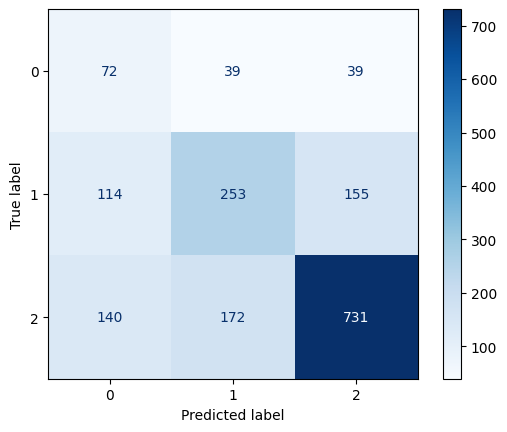

In [53]:
confusion_mat = confusion_matrix(y_test_fold, y_pred)
confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,
                              display_labels=model_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)

Orden de las clases en el modelo:
['1-15' '16-30' '31-60' '>60' 'Puntual']


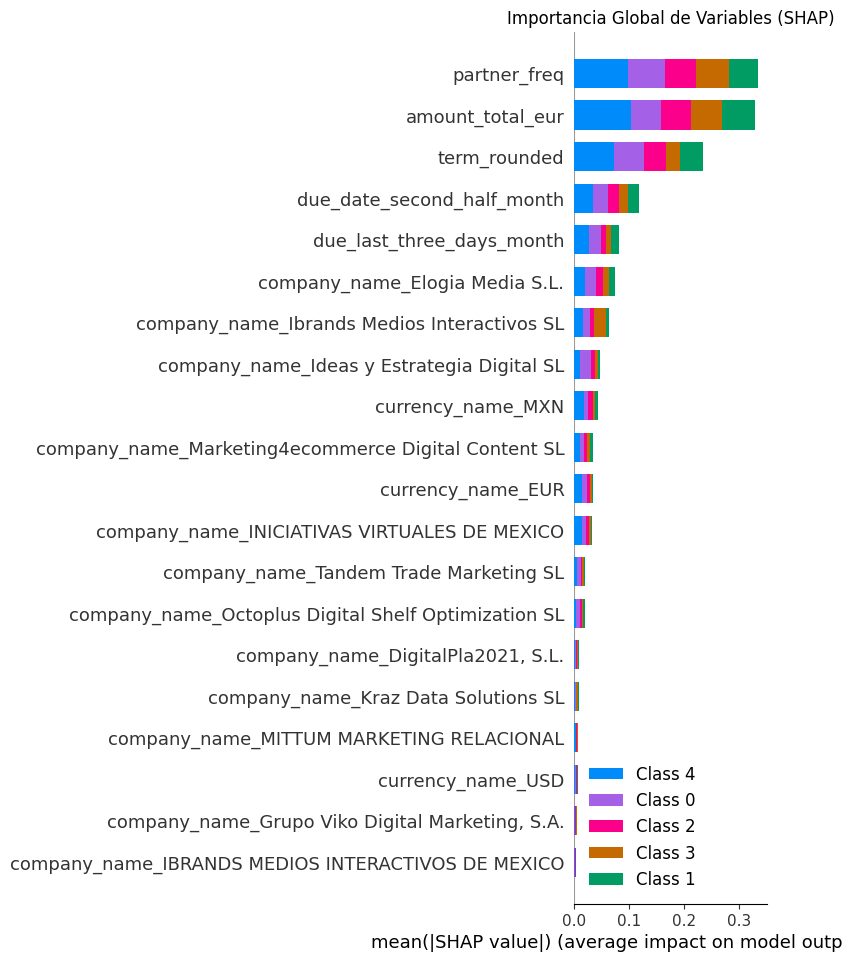

In [ ]:
X_test_sample = X_test.sample(n=100, random_state=42)
preprocessor = model_pipeline.named_steps['preprocessor']
rf_model = model_pipeline.named_steps['classifier']

X_test_transformed = preprocessor.transform(X_test_sample)
categorical_features = ['currency_name', 'company_name']
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

numeric_features = [col for col in X_test_sample.columns if col not in categorical_features]
feature_names = list(ohe_feature_names) + numeric_features


explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_transformed)

print("Orden de las clases en el modelo:")
print(rf_model.classes_)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Importancia Global de Variables (SHAP)")
plt.show()

El modelo baseline sin utilizar un split temporal y sin histórico del cliente consigue un accuracy del 61%, este modelo tiene en cuenta "quién es el cliente" y "cuánto es la factura?" principalmente, este valor de accuracy no es fiable dada el desbalanceo que hay entre clases. Las puntuales lo hace bastante bien con un 76% de F1-score, 1-15 con un 50% pero despues 16-30, 31-60 y más de 60 lo hace mal con un 34%-40%.

## Modelo 2

In [ ]:
features_model_2 = [
    # Identidad y Factura Actual
    'amount_total_eur', 'term_rounded', 'currency_name', 'company_name', 
    'partner_name', 'due_last_three_days_month', 'due_date_second_half_month',
    
    # Historial
    'num_prior_invoices', 
    'num_late_prior_invoices', 
    'ratio_late_prior_invoices',
    'avg_delay_prior_late_invoices', 
    'avg_delay_prior_all', 
    'avg_payment_term_prior_invoices',
    'avg_invoiced_prior', 
    'total_invoice_amount_prior', 
    'total_invoice_amount_late_prior', 
    'ratio_invoice_amount_late_prior',
    'num_outstanding_invoices', 
    'num_outstanding_invoices_late', 
    'ratio_outstanding_invoices_late', 
    'total_invoice_amount_outstanding', 
    'total_invoice_amount_outstanding_late', 
    'ratio_invoice_amount_outstanding_late'
]

target = 'payment_overdue_category'

In [5]:
X = dataset[features_model_2].copy()
y = dataset[target].copy()
le = LabelEncoder()
y = le.fit_transform(y)

Random forest

In [6]:
X['due_last_three_days_month'] = X['due_last_three_days_month'].astype(int)
X['due_date_second_half_month'] = X['due_date_second_half_month'].astype(int)
freq = X['partner_name'].value_counts()
X['partner_freq'] = X['partner_name'].map(freq)
X = X.drop('partner_name', axis=1)

categorical_features = ['currency_name', 'company_name']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

model_v2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

In [83]:
fold = 1

f1_scores = []
accuracy_scores = []

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, y_train = X.iloc[train_index], y[train_index]
    X_test, y_test = X.iloc[test_index], y[test_index]

    model_v2.fit(X_train, y_train)
    y_pred = model_v2.predict(X_test)

    print(f"Fold {fold} Classification Report:")
    print(classification_report(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    accuracy_scores.append(np.mean(y_pred == y_test))
    fold += 1

print(f"Average F1 Score: {np.mean(f1_scores)}")
print(f"Average Accuracy Score: {np.mean(accuracy_scores)}")

Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.48      0.53       351
           1       0.69      0.55      0.61       650
           2       0.64      0.81      0.71       714

    accuracy                           0.64      1715
   macro avg       0.64      0.61      0.62      1715
weighted avg       0.65      0.64      0.64      1715

Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46       251
           1       0.62      0.59      0.61       557
           2       0.79      0.81      0.80       907

    accuracy                           0.69      1715
   macro avg       0.62      0.62      0.62      1715
weighted avg       0.68      0.69      0.69      1715

Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.38      0.43       262
           1       0.61      0.65      

XGBoost

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

model_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=300, 
        max_depth=20,        
        learning_rate=0.01,   
        objective='multi:softprob',
        random_state=42,
        n_jobs=-1
    ))
])


print("Entrenando XGBoost con SMOTE...")
model_smote.fit(X_train, y_train_enc)


y_pred_enc = model_smote.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

print(classification_report(y_test, y_pred))

Entrenando XGBoost con SMOTE...
              precision    recall  f1-score   support

        1-15       0.71      0.66      0.69       530
       16-30       0.42      0.39      0.40       166
       31-60       0.50      0.52      0.51       189
         >60       0.45      0.47      0.46       174
     Puntual       0.83      0.86      0.84      1001

    accuracy                           0.71      2060
   macro avg       0.58      0.58      0.58      2060
weighted avg       0.70      0.71      0.71      2060



Ejecutando Selección de Variables con XGBoost (paciencia)...
Número óptimo de variables: 30

Variables Seleccionadas (30): ['cat__currency_name_EUR', 'cat__currency_name_MXN', 'cat__currency_name_USD', 'cat__company_name_DigitalPla2021, S.L.', 'cat__company_name_Elogia Media S.L.', 'cat__company_name_Grupo Viko Digital Marketing, S.A.', 'cat__company_name_IBRANDS MEDIOS INTERACTIVOS DE MEXICO', 'cat__company_name_INICIATIVAS VIRTUALES DE MEXICO', 'cat__company_name_Ibrands Medios Interactivos SL', 'cat__company_name_Ideas y Estrategia Digital SL', 'cat__company_name_Kraz Data Solutions SL', 'cat__company_name_Marketing4ecommerce Digital Content SL', 'cat__company_name_Octoplus Digital Shelf Optimization SL', 'cat__company_name_Tandem Trade Marketing SL', 'remainder__term', 'remainder__due_last_three_days_month', 'remainder__due_date_second_half_month', 'remainder__num_prior_invoices', 'remainder__num_late_prior_invoices', 'remainder__ratio_late_prior_invoices', 'remainder__avg_delay_pr

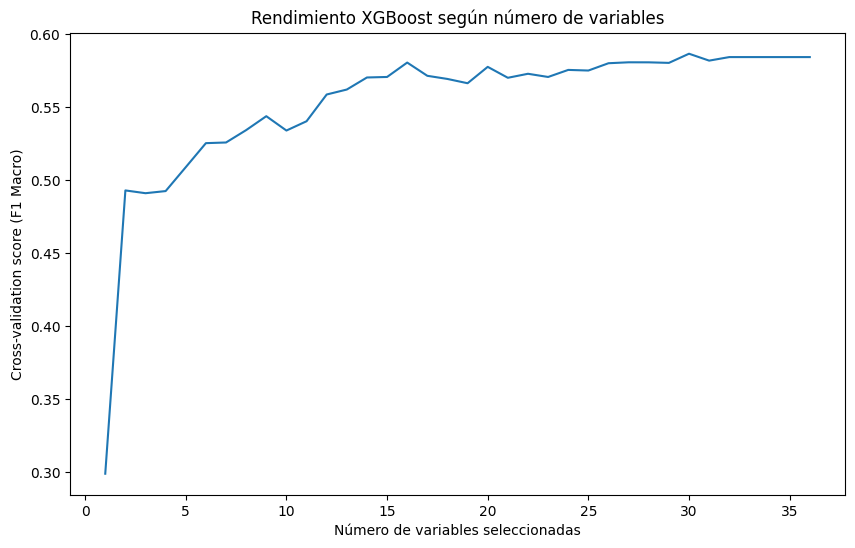

In [9]:

X_transformed = model_v2.named_steps['preprocessor'].fit_transform(X)
feature_names = model_v2.named_steps['preprocessor'].get_feature_names_out()

xgb = XGBClassifier(
    n_estimators=100, 
    max_depth=15,         
    learning_rate=0.1, 
    objective='multi:softprob', 
    n_jobs=-1, 
    random_state=42
)

rfecv = RFECV(
    estimator=xgb,
    step=1,             
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='f1_macro',
    n_jobs=-1
)

print("Ejecutando Selección de Variables con XGBoost (paciencia)...")

rfecv.fit(X_transformed, y)
    
print(f"Número óptimo de variables: {rfecv.n_features_}")

selected_features = [f for f, s in zip(feature_names, rfecv.support_) if s]
print(f"\nVariables Seleccionadas ({len(selected_features)}): {selected_features}")

plt.figure(figsize=(10, 6))
plt.xlabel("Número de variables seleccionadas")
plt.ylabel("Cross-validation score (F1 Macro)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("Rendimiento XGBoost según número de variables")
plt.show()

In [ ]:
param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 500, 700],
    'classifier__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [4, 6, 8, 10, 12, 15], 
    'classifier__min_child_weight': [1, 3, 5, 7, 10], # A mayor número, más conservador con clases pequeñas
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],       # Evita que se ajuste demasiado a filas específicas
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Evita depender de una sola columna fuerte
    'classifier__gamma': [0, 0.1, 0.2, 0.5, 1.0], # Penalización mínima para dividir
    'classifier__reg_alpha': [0, 0.01, 0.1, 1, 10],  # L1
    'classifier__reg_lambda': [0.5, 1, 1.5, 2],      # L2
    'classifier__max_delta_step': [0, 1, 2, 5] # Útil para clases desbalanceadas
}

In [14]:
print(X.head())

       amount_total_eur  term currency_name  \
23781            100.80    48           EUR   
24026           1931.79    30           EUR   
23894            831.98    17           EUR   
24031           1678.51    30           EUR   
23446            121.29    49           EUR   

                                 company_name  due_last_three_days_month  \
23781          Ibrands Medios Interactivos SL                          0   
24026               Tandem Trade Marketing SL                          0   
23894  Marketing4ecommerce Digital Content SL                          0   
24031               Tandem Trade Marketing SL                          1   
23446                       Elogia Media S.L.                          0   

       due_date_second_half_month  num_prior_invoices  \
23781                           0                 0.0   
24026                           0                 0.0   
23894                           0                 0.0   
24031                           

In [18]:
model_v2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100, 
        max_depth=15,         
        learning_rate=0.1, 
        objective='multi:softprob', 
        n_jobs=-1, 
        random_state=42
    ))
])

X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y, test_size=0.15, shuffle=False
)

search = RandomizedSearchCV(
    model_v2,
    param_distributions=param_distributions,
    n_iter=2500,            
    scoring='f1_macro',     
    cv=TimeSeriesSplit(n_splits=4),  
    verbose=1,
    random_state=42,
    n_jobs=-2
)

search.fit(X_train, y_train_enc)

print(f"\n Mejores parámetros:\n{search.best_params_}")
print(f"Mejor F1-Macro (CV): {search.best_score_:.4f}")

best_model = search.best_estimator_
y_pred_enc = best_model.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test_enc)

print("\n--- REPORTE FINAL ---")
print(classification_report(y_test_orig, y_pred))

Fitting 4 folds for each of 2500 candidates, totalling 10000 fits

 Mejores parámetros:
{'classifier__subsample': 0.8, 'classifier__reg_lambda': 2, 'classifier__reg_alpha': 10, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 5, 'classifier__max_depth': 10, 'classifier__max_delta_step': 1, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.8}
Mejor F1-Macro (CV): 0.6110

--- REPORTE FINAL ---
              precision    recall  f1-score   support

       Grave       0.35      0.36      0.36       128
        Leve       0.63      0.56      0.59       469
     Puntual       0.81      0.86      0.83       948

    accuracy                           0.72      1545
   macro avg       0.60      0.59      0.59      1545
weighted avg       0.72      0.72      0.72      1545



In [20]:
joblib.dump(best_model, 'modelo_final.pkl')

['modelo_final.pkl']